<a href="https://colab.research.google.com/github/asetya/BigData/blob/master/ImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**praktikum mesin learning untuk image recognition menggunakan fitur global **



terdapat 2 buah file, file pertama digunakan untuk menulis fungsi fungsi ekstraksi fitur, file kedua untuk melakukan klasifikasi dan evaluasi 

1. buka google colab https://colab.research.google.com/
2. buat notebook baru 
3. buat blok kode program dengan mengklik +code 
4. jalankan setiap blok kode program dengan mengklik tanda panah ke kanan untuk setiap blok 


In [9]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import mahotas
import cv2
import os
import h5py

jika terdapat pesan bahwa library mahotas tidak ada seperti di bawah ini :
 

```
ModuleNotFoundError                       Traceback (most recent call last)
<ipython-input-1-717b2196b28a> in <module>()
      2 from sklearn.preprocessing import MinMaxScaler
      3 import numpy as np
----> 4 import mahotas
      5 import cv2
      6 import os

ModuleNotFoundError: No module named 'mahotas'

---------------------------------------------------------------------------
NOTE: If your import is failing due to a missing package, you can
manually install dependencies using either !pip or !apt.

To view examples of installing some common dependencies, click the
"Open Examples" button below.
```


 (ModuleNotFoundError: No module named 'mahotas')
 
 tidak di temukan silakan jalankan blok program di bawah ini, dengan mengaktikan dulu kodenya dengan menghapus tanda #

setelah selesai, non aktifkan perintah instal mahotas dan  kembali jalankan blok yang error tadi



In [2]:
#!pip install mahotas

     |████████████████████████████████| 5.7MB 4.0MB/s 


jika terdapat pesan bahwa libray cv2 tidak di temukan silakan jalankan blok program di bawah ini, dengan mengaktikan dulu kodenya dengan menghapus tanda #


In [3]:
#!pip install opencv-contrib-python==3.4.0.12

     |████████████████████████████████| 30.5MB 141kB/s 
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


Hubungkan kode program ini dengan google drive kita


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


output yang diharapkan : 

Mounted at /content/drive

Copy Dataset dari lokal ke server google colab

In [5]:
cp /content/drive/My\ Drive/dataset1.zip /content/

**unzip dataset di server google colab**

In [6]:
!unzip /content/dataset1.zip

Archive:  /content/dataset1.zip
   creating: dataset1/dataset1/
  inflating: dataset1/dataset1/desktop.ini  
   creating: dataset1/dataset1/test/
  inflating: dataset1/dataset1/test/1.jpg  
  inflating: dataset1/dataset1/test/2.jpg  
  inflating: dataset1/dataset1/test/3.jpg  
  inflating: dataset1/dataset1/test/76.jpg  
  inflating: dataset1/dataset1/test/77.jpg  
  inflating: dataset1/dataset1/test/78.jpg  
  inflating: dataset1/dataset1/test/79.jpg  
  inflating: dataset1/dataset1/test/80.jpg  
  inflating: dataset1/dataset1/test/desktop.ini  
   creating: dataset1/dataset1/train/
   creating: dataset1/dataset1/train/bluebell/
  inflating: dataset1/dataset1/train/bluebell/1.jpg  
  inflating: dataset1/dataset1/train/bluebell/10.jpg  
  inflating: dataset1/dataset1/train/bluebell/11.jpg  
  inflating: dataset1/dataset1/train/bluebell/12.jpg  
  inflating: dataset1/dataset1/train/bluebell/13.jpg  
  inflating: dataset1/dataset1/train/bluebell/14.jpg  
  inflating: dataset1/dataset1/tr

output yang diharapkan : 



```
Archive:  /content/dataset1.zip
  inflating: dataset1/desktop.ini    
  inflating: dataset1/test/desktop.ini  
   creating: dataset1/train/
   creating: dataset1/train/bluebell/
  inflating: dataset1/train/bluebell/1.jpg  
  inflating: dataset1/train/bluebell/10.jpg  
  inflating: dataset1/train/bluebell/11.jpg  
  inflating: dataset1/train/bluebell/12.jpg  
  inflating: dataset1/train/bluebell/13.jpg  
  inflating: dataset1/train/bluebell/14.jpg  
  inflating: dataset1/train/bluebell/15.jpg  
  inflating: dataset1/train/bluebell/16.jpg  
  ....
```



tentukan jumlah image per kelas, ukuran standard, nama folder di mana data training disimpan, output dan jumlah bins untuk histogram 

In [7]:
images_per_class = 80
fixed_size       = tuple((500, 500))
train_path       = "dataset1/dataset1/train"
h5_data          = 'output/data.h5'
h5_labels        = 'output/labels.h5'
bins             = 8
print("jumlah image per kelas : ", images_per_class, "train path : ", train_path, "; file h5 untuk label : ",h5_labels, ";jumlah bins dalam histogram :", bins)

jumlah image per kelas :  80 train path :  dataset1/dataset1/train ; file h5 untuk label :  output/labels.h5 ;jumlah bins dalam histogram : 8


output yang diharapkan : 

jumlah image per kelas :  80 train path :  dataset1/train ; file h5 untuk label :  output/labels.h5 ;jumlah bins dalam histogram : 8

jalankan perintah untuk membuat direktori output

In [10]:
output_path="output"
if not os.path.exists(output_path ):
    os.makedirs(output_path )
print(output_path)

output


output yang di harapkan 

output

Fungsi untuk mengektraksi fitur hu moments

In [11]:
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

**fungsi untuk mencari haralick feature**

In [12]:
def fd_haralick(image):
    # convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # compute the haralick texture feature vector
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    # return the result
    return haralick


**Fungsi untuk ekstraksi histogram**

In [13]:
def fd_histogram(image, mask=None):
    # convert the image to HSV color-space
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # compute the color histogram
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    # normalize the histogram
    cv2.normalize(hist, hist)
    # return the histogram
    return hist.flatten()

**Program utama untuk membaca semua image pada training dataset dan mengekstraksi fitur hu moments, haralick fitur dan histogram colour dari masing masing image**


1. membaca daftar sub folder pada path dimana dataset training berada : train_path       = "dataset1/train"
2. jika di perhatikan di dalam folder train ada beberapa folder dan 1 file 

In [14]:
train_labels = os.listdir(train_path)
print(train_labels)
# sort the training labels
train_labels.sort()
print(train_labels)

# empty lists to hold feature vectors and labels
global_features = []
labels          = []

['bluebell', 'coltsfoot', 'buttercup', 'desktop.ini']
['bluebell', 'buttercup', 'coltsfoot', 'desktop.ini']


output yang diharapkan : 


```
['buttercup', 'coltsfoot', 'bluebell', 'desktop.ini']
['bluebell', 'buttercup', 'coltsfoot', 'desktop.ini']
```



3. Kode program untuk perulangan sebanyak train_labels (jumlah sub folder pada train_path 
4. pastikan yang di dalam folder train adalah folder - bukan file
5. ulangi untuk semua image dalam setiap folder sampai dengan maksimal sebanyak variabel image_perclass 
6. untuk setiap image - ubah ukuran menjadi ukuran standard dengan perintah resize 
7. ekstrak fitur haralic, hu dan histogram dari setiap image 
8. gabungkan semua fitur global menjadi 1 lalu simpan variabel global_feature 
9. untuk setiap perulangan selesai - simpan variabel global_features ke dalam array global_features sebagai baris baru dengan perintah append

In [15]:
for training_name in train_labels:
  dir = os.path.join(train_path, training_name)
  if os.path.isdir(dir):
    print(dir)
    print(" adalah folder")
    current_label = training_name
    for x in range(1,images_per_class+1):
          # get the image file name
          file = dir + "/" + str(x) + ".jpg"

          # read the image and resize it to a fixed-size
          image = cv2.imread(file)
          image = cv2.resize(image, fixed_size)

          ####################################
          # Global Feature extraction
          ####################################
          fv_hu_moments = fd_hu_moments(image)
          fv_haralick   = fd_haralick(image)
          fv_histogram  = fd_histogram(image)

          ###################################
          # Concatenate global features
          ###################################
          global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])

          # update the list of labels and feature vectors
          labels.append(current_label)
          global_features.append(global_feature)
    print("[STATUS] processed folder: {}".format(current_label))
 


  



dataset1/dataset1/train/bluebell
 adalah folder
[STATUS] processed folder: bluebell
dataset1/dataset1/train/buttercup
 adalah folder
[STATUS] processed folder: buttercup
dataset1/dataset1/train/coltsfoot
 adalah folder
[STATUS] processed folder: coltsfoot


output yang diharapkan : 



```
dataset1/train/bluebell
 adalah folder
[STATUS] processed folder: bluebell
dataset1/train/buttercup
 adalah folder
[STATUS] processed folder: buttercup
dataset1/train/coltsfoot
 adalah folder
[STATUS] processed folder: coltsfoot
```



**End Loop Training untuk seluruh sub folder **


tampilkan ukuran vektor global features 

tampilkan array training labels 

In [16]:
# get the overall feature vector size
print("[STATUS] feature vector size {}".format(np.array(global_features).shape))

# get the overall training label size
print("[STATUS] training Labels {}".format(np.array(labels).shape))



[STATUS] feature vector size (240, 532)
[STATUS] training Labels (240,)


[STATUS] feature vector size (240, 532)
[STATUS] training Labels (240,)

Encoding target label 

In [17]:
# encode the target labels
targetNames = np.unique(labels)
le          = LabelEncoder()
target      = le.fit_transform(labels)
print("[STATUS] training labels encoded...")



[STATUS] training labels encoded...


output di harapkan 

[STATUS] training labels encoded...

Standarisasi nilai vektor menjadi 0 sampai dengan 1 untuk semua data 

In [18]:
# scale features in the range (0-1)
scaler            = MinMaxScaler(feature_range=(0, 1))
rescaled_features = scaler.fit_transform(global_features)
print("[STATUS] feature vector normalized...")

print("[STATUS] target labels: {}".format(target))
print("[STATUS] target labels shape: {}".format(target.shape))



[STATUS] feature vector normalized...
[STATUS] target labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[STATUS] target labels shape: (240,)


outout di harapkan : 



```
[STATUS] feature vector normalized...
[STATUS] target labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[STATUS] target labels shape: (240,)
```



simpan semua data ke lam file h5 dan disimpan dalam folder yang telah diset pada bagian awal program ini

In [19]:
# save the feature vector using HDF5
h5f_data = h5py.File(h5_data, 'w')
h5f_data.create_dataset('dataset_1', data=np.array(rescaled_features))

h5f_label = h5py.File(h5_labels, 'w')
h5f_label.create_dataset('dataset_1', data=np.array(target))

h5f_data.close()
h5f_label.close()

print("[STATUS] end of Feature Extraction..")    


[STATUS] end of Feature Extraction..


Output di harapkan : 

[STATUS] end of Feature Extraction..

# **Kode Program Lanjutan di bawah ini adalah untuk melakukan training dan Testing terhadap fitur yang sudah di ekstraks untuk beberapa algoritma klasifikasi **

Import tambahan library yang diperlukan 

In [20]:

import glob
import warnings
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.externals import joblib
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


Mengeset variabel yang dapat ditune
jika lanjutan ini di file terpisah dapat di tambahkan : 


```
# This is formatted as code
train_path = "dataset/train"
h5_data    = 'output/data.h5'
h5_labels  = 'output/labels.h5'
```



In [21]:
# tunable-parameters
#--------------------
num_trees = 100
test_size = 0.10
seed      = 9
scoring    = "accuracy"
test_path  = "dataset1/dataset1/test"


Menambahkan folder test jika belum ada 

In [22]:
if not os.path.exists(test_path):
    os.makedirs(test_path)

Menginisialisasi model klasifier 


In [23]:
models = []
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state=seed)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, random_state=seed)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(random_state=seed)))

# variables to hold the results and names
results = []
names   = []
print (models)

[('LR', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=9, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)), ('LDA', LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)), ('KNN', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')), ('CART', DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
      

Output yang diharapkan :

```
# This is formatted as code

[('LR', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=9, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)), ('LDA', LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)),
                            ('KNN', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')), ('CART', DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=9, splitter='best')), ('RF', RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=9, verbose=0,
                       warm_start=False)), ('NB', GaussianNB(priors=None, var_smoothing=1e-09)), ('SVM', SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=9, shrinking=True, tol=0.001,
    verbose=False))]
```



```
# This is formatted as code
```



Membaca file h5 dimana hasil ekstraki fitur disimpan 
ini tidak perlu jika program lanjutan ini tidak menjadi file terpisah 


In [24]:
h5f_data  = h5py.File(h5_data, 'r')
h5f_label = h5py.File(h5_labels, 'r')

print(h5f_data)
print(h5f_label)

<HDF5 file "data.h5" (mode r)>
<HDF5 file "labels.h5" (mode r)>


outr=put diharapkan : 



```
<HDF5 file "data.h5" (mode r)>
<HDF5 file "labels.h5" (mode r)>
```



menyimpan fitur 

In [25]:
global_features_string = h5f_data['dataset_1']
global_labels_string   = h5f_label['dataset_1']

global_features = np.array(global_features_string)
global_labels   = np.array(global_labels_string)

print(global_features)
print(global_labels_string)



[[1.02277289e-02 6.41539399e-02 3.80293751e-01 ... 8.69740569e-01
  6.21634972e-02 8.80157045e-01]
 [2.70794117e-05 2.24351000e-02 1.26657213e-02 ... 8.69741443e-01
  6.21926975e-02 8.80154788e-01]
 [0.00000000e+00 3.14553867e-02 1.64679193e-02 ... 8.69741419e-01
  6.21939464e-02 8.80158524e-01]
 ...
 [6.83042966e-03 1.17875410e-02 1.00131224e-02 ... 8.69668780e-01
  5.76707307e-02 8.80238908e-01]
 [1.42973036e-02 3.31645389e-02 2.45463253e-02 ... 8.69637236e-01
  6.18151726e-02 8.80100514e-01]
 [1.60889028e-03 9.45723423e-04 3.74527032e-03 ... 8.69873367e-01
  6.80346632e-02 8.80016124e-01]]
<HDF5 dataset "dataset_1": shape (240,), type "<i8">


output diharapkan : 


```
[[1.02277289e-02 6.41539399e-02 3.80293751e-01 ... 8.69740569e-01
  6.21634972e-02 8.80157045e-01]
 [2.70794117e-05 2.24351000e-02 1.26657213e-02 ... 8.69741443e-01
  6.21926975e-02 8.80154788e-01]
 [0.00000000e+00 3.14553867e-02 1.64679193e-02 ... 8.69741419e-01
  6.21939464e-02 8.80158524e-01]
 ...
 [6.83042966e-03 1.17875410e-02 1.00131224e-02 ... 8.69668780e-01
  5.76707307e-02 8.80238908e-01]
 [1.42973036e-02 3.31645389e-02 2.45463253e-02 ... 8.69637236e-01
  6.18151726e-02 8.80100514e-01]
 [1.60889028e-03 9.45723423e-04 3.74527032e-03 ... 8.69873367e-01
  6.80346632e-02 8.80016124e-01]]
<HDF5 dataset "dataset_1": shape (720,), type "<i8">
```



Menutup file h5 
ini tidak perlu di eksekusi jika tadi tidak di buka 

In [26]:
h5f_data.close()
h5f_label.close()

menampilkan ukuran fitur dan label dari hasil ekstraksi fitur global images 

In [27]:
# verify the shape of the feature vector and labels
print("[STATUS] features shape: {}".format(global_features.shape))
print("[STATUS] labels shape: {}".format(global_labels.shape))

[STATUS] features shape: (240, 532)
[STATUS] labels shape: (240,)


melakukan pembagian dataset menjadi train dan testing dataset 

In [28]:
(trainDataGlobal, testDataGlobal, trainLabelsGlobal, testLabelsGlobal) = train_test_split(np.array(global_features),
                                                                                          np.array(global_labels),
                                                                                          test_size=test_size,
                                                                                          random_state=seed)

print("[STATUS] splitted train and test data...")
print("Train data  : {}".format(trainDataGlobal.shape))
print("Test data   : {}".format(testDataGlobal.shape))
print("Train labels: {}".format(trainLabelsGlobal.shape))
print("Test labels : {}".format(testLabelsGlobal.shape))

[STATUS] splitted train and test data...
Train data  : (216, 532)
Test data   : (24, 532)
Train labels: (216,)
Test labels : (24,)


output yang diharapkan : 

[STATUS] splitted train and test data...

Train data  : (216, 532)

Test data   : (24, 532)

Train labels: (216,)

Test labels : (24,)

Melatih model dan menghitung akurasi dari masing masing model yang berbeda klasiifier 

In [29]:
for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, trainDataGlobal, trainLabelsGlobal, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.883550 (0.053308)
LDA: 0.480952 (0.102552)
KNN: 0.800000 (0.095534)
CART: 0.847186 (0.042528)
RF: 0.934848 (0.037270)
NB: 0.786147 (0.127983)
SVM: 0.879004 (0.044374)


output yang diharapkan : 



```
LR: 0.986130 (0.016064)
LDA: 0.983005 (0.023373)
KNN: 0.841034 (0.041933)
CART: 1.000000 (0.000000)
RF: 0.996923 (0.009231)
NB: 0.870433 (0.019381)
SVM: 0.970721 (0.018744)
```



Plot akurasi dan deviasi dalam box plot diagram 



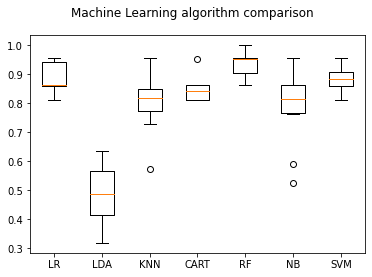

In [30]:
# boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('Machine Learning algorithm comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()


output yang diharapkan  adalah blok plot 

membuat model random forest 


In [32]:
import matplotlib.pyplot as plt

# create the model - Random Forests
clf  = RandomForestClassifier(n_estimators=num_trees, random_state=seed)

# fit the training data to the model
clf.fit(trainDataGlobal, trainLabelsGlobal)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=9, verbose=0,
                       warm_start=False)

output yanmg diharapkan : 



```
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=9, verbose=0,
                       warm_start=False)
```



In [ ]:
melakukan testing pada image yang ada di dalam test folder 


In [33]:
test_path

for file in glob.glob(test_path + "/*.jpg"):
  print(file)


dataset1/dataset1/test/77.jpg
dataset1/dataset1/test/80.jpg
dataset1/dataset1/test/78.jpg
dataset1/dataset1/test/3.jpg
dataset1/dataset1/test/1.jpg
dataset1/dataset1/test/2.jpg
dataset1/dataset1/test/76.jpg
dataset1/dataset1/test/79.jpg


In [38]:
global_features1=[]
for file in glob.glob(test_path + "/*.jpg"):
    # read the image
    image = cv2.imread(file)

    # resize the image
    image = cv2.resize(image, fixed_size)

    ####################################
    # Global Feature extraction
    ####################################
    fv_hu_moments = fd_hu_moments(image)
    fv_haralick   = fd_haralick(image)
    fv_histogram  = fd_histogram(image)

    ###################################
    # Concatenate global features
    ###################################
    global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])
    
    global_features1.append(global_feature)

In [39]:
global_features1.shape()

AttributeError: ignored

In [35]:
# scale features in the range (0-1)
scaler = MinMaxScaler(feature_range=(0, 1))
rescaled_feature = scaler.fit_transform(global_feature)

# predict label of test image
prediction = clf.predict(rescaled_feature.reshape(1,-1))[0]

    # show predicted label on image
cv2.putText(image, train_labels[prediction], (20,30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,255), 3)

    # display the output image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

ValueError: ignored

In [36]:
for file in glob.glob(test_path + "/*.jpg"):
    # read the image
    image = cv2.imread(file)

    # resize the image
    image = cv2.resize(image, fixed_size)

    ####################################
    # Global Feature extraction
    ####################################
    fv_hu_moments = fd_hu_moments(image)
    fv_haralick   = fd_haralick(image)
    fv_histogram  = fd_histogram(image)

    ###################################
    # Concatenate global features
    ###################################
    global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])

# scale features in the range (0-1)
scaler = MinMaxScaler(feature_range=(0, 1))
rescaled_feature = scaler.fit_transform(global_feature)

# predict label of test image
prediction = clf.predict(rescaled_feature.reshape(1,-1))[0]

    # show predicted label on image
cv2.putText(image, train_labels[prediction], (20,30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,255), 3)

    # display the output image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

ValueError: ignored